In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
import requests
from lxml import html
import plotly.express as px
from bs4 import BeautifulSoup

In [2]:
ms1877_1967 = pd.read_csv('match_scores/match_scores_1877-1967_unindexed_csv.csv')
ms1968_1990 = pd.read_csv('match_scores/match_scores_1968-1990_unindexed_csv.csv')
ms1991_2016 = pd.read_csv('match_scores/match_scores_1991-2016_unindexed_csv.csv')

ms1877_1990 = ms1877_1967.append(ms1968_1990)

ms1877_2016 = ms1877_1990.append(ms1991_2016)

years = []
for year in ms1877_2016['tourney_year_id']:
    years.append(year[0:4])

ms1877_2016.insert(0, 'year', years)
ms1877_2016.head()

,year,tourney_year_id,tourney_order,tourney_slug,tourney_url_suffix,tourney_round_name,round_order,match_order,winner_name,winner_player_id,...,loser_seed,match_score_tiebreaks,winner_sets_won,loser_sets_won,winner_games_won,loser_games_won,winner_tiebreaks_won,loser_tiebreaks_won,match_id,match_stats_url_suffix
0,1877,1877-540,1,wimbledon,/en/scores/archive/wimbledon/540/1877/results,Finals,1,1,Spencer Gore,gi91,...,NaN,61 62 64,3,0,18,7,0,0,1877-540-gi91-mu62,NaN
1,1877,1877-540,1,wimbledon,/en/scores/archive/wimbledon/540/1877/results,Semi-Finals,2,1,Spencer Gore,gi91,...,NaN,62 65 62,3,0,18,9,0,0,1877-540-gi91-hg42,NaN
2,1877,1877-540,1,wimbledon,/en/scores/archive/wimbledon/540/1877/results,Quarter-Finals,3,1,Spencer Gore,gi91,...,NaN,63 62 56 61,3,1,23,12,0,0,1877-540-gi91-lh23,NaN
3,1877,1877-540,1,wimbledon,/en/scores/archive/wimbledon/540/1877/results,Quarter-Finals,3,2,C. Heathcote,hg42,...,NaN,63 63 65,3,0,18,11,0,0,1877-540-hg42-mu66,NaN
4,1877,1877-540,1,wimbledon,/en/scores/archive/wimbledon/540/1877/results,Quarter-Finals,3,3,William Marshall,mu62,...,NaN,65 56 64 61,3,1,23,16,0,0,1877-540-mu62-e994,NaN


In [3]:
# Combine data from 1877 to 2016 to get a more complete picture
ms1877_2016.to_csv('match_scores_1877-2016.csv')

In [4]:
ms1877_2016 = pd.read_csv('match_scores_1877-2016.csv', low_memory=False)

In [5]:
# likelyhood of an upset by year
# upset is defined as the player seeded "n" spots lower winning the match
# for each match, if the winner seed is greater than the loser seed by "n", then the match was an upset
# if done by year, add the tourney year id and the number of upsets for that year across all tournaments
# if done by tournament, add the tournament and the number of total upsets since the tournament began
# if done by round, add the round and the number of upsets at that round in the particular tournament

# Determining upsets by year and by tournament

### get_upsets()
Purpose: Define what constitutes an upset and return a datframe with all rows containing an upset
- First I mad a dataframe called upsets that consists of every row from ms1877_2016 where the winner_seed value is greater than the loser_seed value. I experimented with a seed difference variable that would allow you to change the way an upset is determined. Currently the seed_difference is 1 which overclassifies upsets. 

### get_upsets_by_tournament()
Purpose: Find the number of upsets that occured at each tournamnet. The output dictionary of this function can also be fed into the percent_upsets_by_tournament() function.
- The function creates a list of unique tournament names to iterate through and to serve as the keys of the output dictionary. 
- Create the output dictionary
- Iterate through our list of tournaments
    - add the tournament name as a key and the length of a dataframe where the tournament name is in the tourney_slug column as a value
- Return the dictionary

### get_upsets_by_year()
Purpose: Find the number of upsets that occured each year. The output dictionary can be fed into the percent_upsets() function to compare the years to each other.
- Create a list of unique years to iterate through and to serve as keys for the output dict
- The value of our new dictionary should be the number of upsets that occured in that year
- This dictionary can be fed into the percent_upsets() function to compare the frequency of upsets through the years

### percent_upsets()
Purpose: The upsets by tournament data is not useful for comparing upsets between tournaments because some tournamnets have been running for longer or have larger draws. For this reason, we must make a similar dictionary that divides the number of upsets by the number of total matches played.
- We take in the dictionary we made with the tournaments and their upsets
- Create our output dictionary
- For each key of our input dictionary
    - Add an entry to our output dictionary with the same key and that key's value divided by the total number of matches played at that tournament
- Return percent_tournament_upsets

In [6]:
##generate a df of all matches determined to be upsets by the winner_seed, loser_seed methodology
def get_upsets(seed_difference=3):
    # seed_difference is how much lower the winning player needs to be seeded in order to classify the match as an upset
    upsets = ms1877_2016.loc[ms1877_2016['winner_seed'] > ms1877_2016['loser_seed']]
    print('There are {} many upsets with a seed difference of {}'.format(len(upsets), 1))
    #upsets = ms1877_2016.loc[int(ms1877_2016['winner_seed']) - int(ms1877_2016['loser_seed']) == seed_difference] # loser seed is a str?
    #print('There are {} many upsets with a seed difference of {}'.format(len(upsets), seed_difference))
    #upset_indexes = []
    #for i in range(len(ms1877_2016)):
    #    if df['winner_seed'].astype(float) - df['loser_seed'].astype(float) > seed_difference:
    #        upset_indexes.append(i)
    #    else:
    #        pass
    #
    #upsets = ms1877_2016.iloc[upset_indexes]
    return upsets

upsets = get_upsets(4)

#to find upsets by tournament, get a list of unique tournaments and then get the length of the upsets df where tourney_slug is equal to the tourney
def get_upsets_by_tournament(): # upsets per match
    tournaments = upsets.tourney_slug.unique() #make a list to iterate through
    tournament_upsets = {} # store our findings in a digestable format
    for t in tournaments: # do this for each tournament
        tournament_upsets[t] = len(upsets.loc[upsets['tourney_slug'] == t]) # the len() statement is the amount of upsets under the given condition
    return tournament_upsets # return our dictionary of findings

def percent_upsets(dict, col_name):
    #print('Tournament Dict: {}\ncol_name: {}'.format(tournament_dict, col_name))
    percent_key_upsets = {}
    for key in dict.keys(): # keys is a list of tournaments that we want to find percent upsets for each
        perc_upsets = int(dict[key]) / len(ms1877_2016.loc[ms1877_2016[col_name] == key])
        percent_key_upsets[key] = perc_upsets
    return percent_key_upsets

# This function returns the number of upsets in a year as a percentage
def get_upsets_by_year():
    years = upsets.year.unique()
    tournament_upsets = {}
    for year in years:
        tournament_upsets[year] = len(upsets.loc[upsets['year'] == year])
    return tournament_upsets

# this function finds the number of upsets by each tournament since the australian open in 1925
def get_upsets_by_year_tourney():
    years = upsets.tourney_year_id.unique()
    tournament_upsets = {}
    for year in years:
        tournament_upsets[year] = len(upsets.loc[upsets['tourney_year_id'] == year])
    return tournament_upsets

upsets_by_year = get_upsets_by_year()
upsets_by_tourney = get_upsets_by_tournament()
upsets_by_year_and_tourney = get_upsets_by_year_tourney()
#print(upsets_by_tourney)
#print(upsets_by_year_and_tourney)
percent_tournament_upsets = percent_upsets(upsets_by_tourney, 'tourney_slug')
percent_annual_upsets = percent_upsets(upsets_by_year, 'year')
#percent_tournament_upsets
#percent_annual_upsets

There are 11047 many upsets with a seed difference of 1


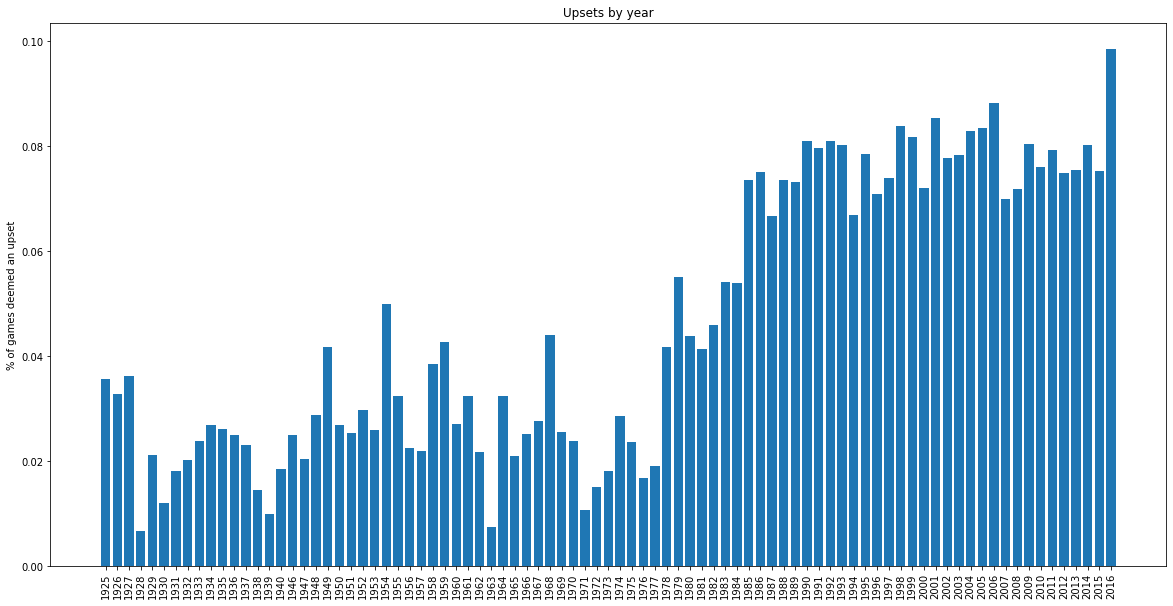

In [7]:
plt.figure(figsize=(20,10))
plt.title('Upsets by year')
plt.bar(range(len(percent_annual_upsets.keys())), list(percent_annual_upsets.values()), align='center')
plt.xticks(range(len(percent_annual_upsets)), list(percent_annual_upsets.keys()), rotation=90)
plt.ylabel('% of games deemed an upset')
plt.show()

In [8]:
data = pd.DataFrame.from_dict(percent_tournament_upsets, orient='index', columns=['% upsets'])
#data = data.reindex(range(len(percent_tournament_upsets)))

In [9]:
records = {'Tournaments': list(percent_tournament_upsets.keys()), '% upsets': list(percent_tournament_upsets.values())}
dff = pd.DataFrame.from_records(records, columns=records.keys())
dff.sort_values('% upsets', ascending=False)
dff.to_csv('percent_tournament_upsets.csv')
dff.head()

,Tournaments,% upsets
0,australian-open,0.052632
1,roland-garros,0.053247
2,wimbledon,0.027126
3,us-open,0.024885
4,bournemouth,0.027184


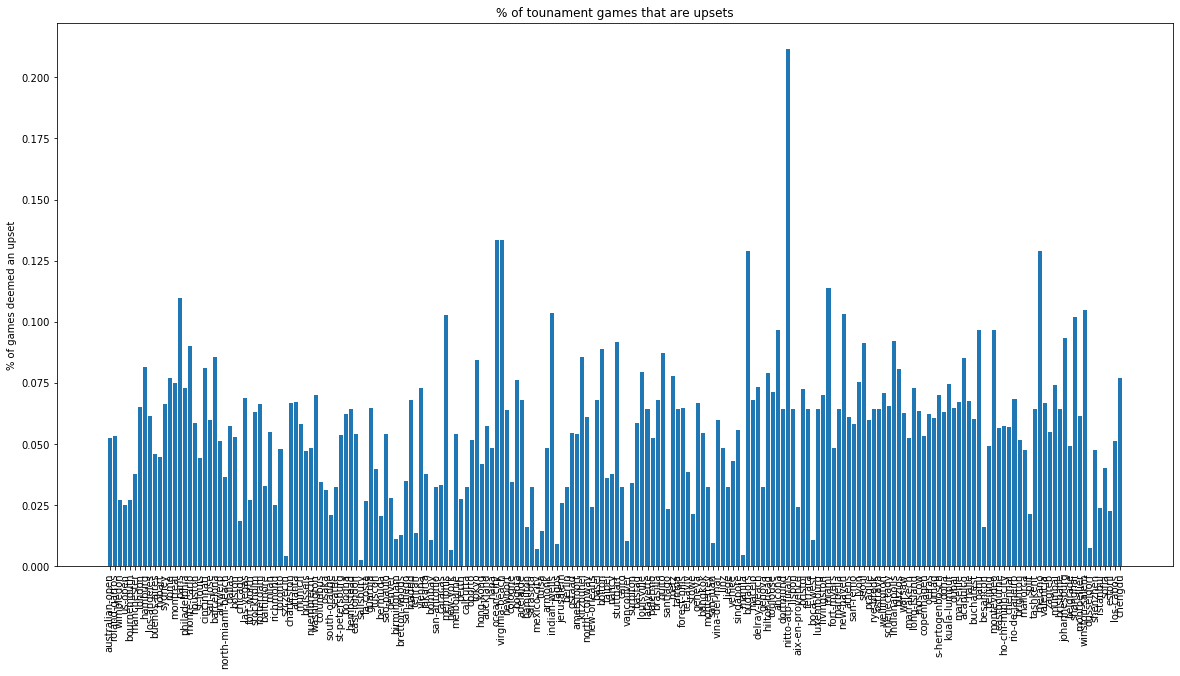

In [10]:
plt.figure(figsize=(20,10))
plt.title('% of tounament games that are upsets')
plt.bar(range(len(percent_tournament_upsets)), list(percent_tournament_upsets.values()), align='center')
plt.xticks(range(len(percent_tournament_upsets)), list(percent_tournament_upsets.keys()), rotation=90)
plt.ylabel('% of games deemed an upset')
plt.show()

In [11]:
ms1877_2016.head()

,Unnamed: 0,year,tourney_year_id,tourney_order,tourney_slug,tourney_url_suffix,tourney_round_name,round_order,match_order,winner_name,...,loser_seed,match_score_tiebreaks,winner_sets_won,loser_sets_won,winner_games_won,loser_games_won,winner_tiebreaks_won,loser_tiebreaks_won,match_id,match_stats_url_suffix
0,0,1877,1877-540,1,wimbledon,/en/scores/archive/wimbledon/540/1877/results,Finals,1,1,Spencer Gore,...,NaN,61 62 64,3,0,18,7,0,0,1877-540-gi91-mu62,NaN
1,1,1877,1877-540,1,wimbledon,/en/scores/archive/wimbledon/540/1877/results,Semi-Finals,2,1,Spencer Gore,...,NaN,62 65 62,3,0,18,9,0,0,1877-540-gi91-hg42,NaN
2,2,1877,1877-540,1,wimbledon,/en/scores/archive/wimbledon/540/1877/results,Quarter-Finals,3,1,Spencer Gore,...,NaN,63 62 56 61,3,1,23,12,0,0,1877-540-gi91-lh23,NaN
3,3,1877,1877-540,1,wimbledon,/en/scores/archive/wimbledon/540/1877/results,Quarter-Finals,3,2,C. Heathcote,...,NaN,63 63 65,3,0,18,11,0,0,1877-540-hg42-mu66,NaN
4,4,1877,1877-540,1,wimbledon,/en/scores/archive/wimbledon/540/1877/results,Quarter-Finals,3,3,William Marshall,...,NaN,65 56 64 61,3,1,23,16,0,0,1877-540-mu62-e994,NaN


# Find Career Length of champions

### get_champions_df()
purpose: This function takes in a dataframe of finals matches since 1877 and returns a dataframe of every player who won a final, their first major win and the length of their career which is on average 16 years. (career ends with the player's last won match)
- The finals_df param is expecting a dataframe of finals matches that it will use to determine who is considered a "champion" and when their career started and ended.
- The min_career_length param is what qualifies someone as a champion or not. In order to be a champion you need to be winning matches for at least (10, default) years.
- I noted a discrepency in the methodology of collecting the length_of_career stat and that is that the df used to calculate negth_of_career is made up of only victories so someone could be losing matches for another 2 years and that would not be counted as part of their career

### Notes on the graph
- Each blue horizontal bar represents a single champion's career. The bar shows how long they were winning matches in years.
- Something I didnt expect the graph to illustrate was the change in shape that occured at around 1960. I take this to mean that there were more champions who's careers were overlapping which means that the game was more competitive.

In [12]:
# Find the average length of career for all champions
 # first get a list of all champions
 # then for each one of them, find the year of their first tournament and their last tournament
def get_champions_df(finals_df, min_career_length=10):
    num_of_finals = {}
    length_of_career = []
    names = []
    start_of_career = []
    for name in finals_df['winner_name']:
        career = ms1877_2016.loc[(ms1877_2016['winner_name'] == name)][['year', 'winner_name']]
        if name not in names and int(max(career['year'])) - int(min(career['year'])) > min_career_length:
            names.append(name)
            length_of_career.append(int(max(career['year'])) - int(min(career['year'])))
            start_of_career.append(int(min(career['year'])))
    records = {'Name': names, 'Length of career': length_of_career, 'Career start': start_of_career}
    df = pd.DataFrame.from_dict(records)
    print(len(df))
    return df
        #Noted discrepency: Because we are using the winner name column, this does not account for a match that someone played and lost so there could be some 
        #length_of_career[name] = int(max(career['year'])) - int(min(career['year']))

In [28]:
#get list of champions based on 2 criteria: they must have won a final and had a carreer of at least n=15 years
finals = ms1877_2016.loc[ms1877_2016['tourney_round_name'] == 'Finals'] # Finals can serve as a list of champions
champs = get_champions_df(finals, 15)

89


In [27]:
champs.head()

,Name,Length of career,Career start
0,Henry Slocum,29,1884
1,Arthur Gore,29,1891
2,William Larned,20,1891
3,Holcombe Ward,21,1896
4,Beals Wright,21,1897


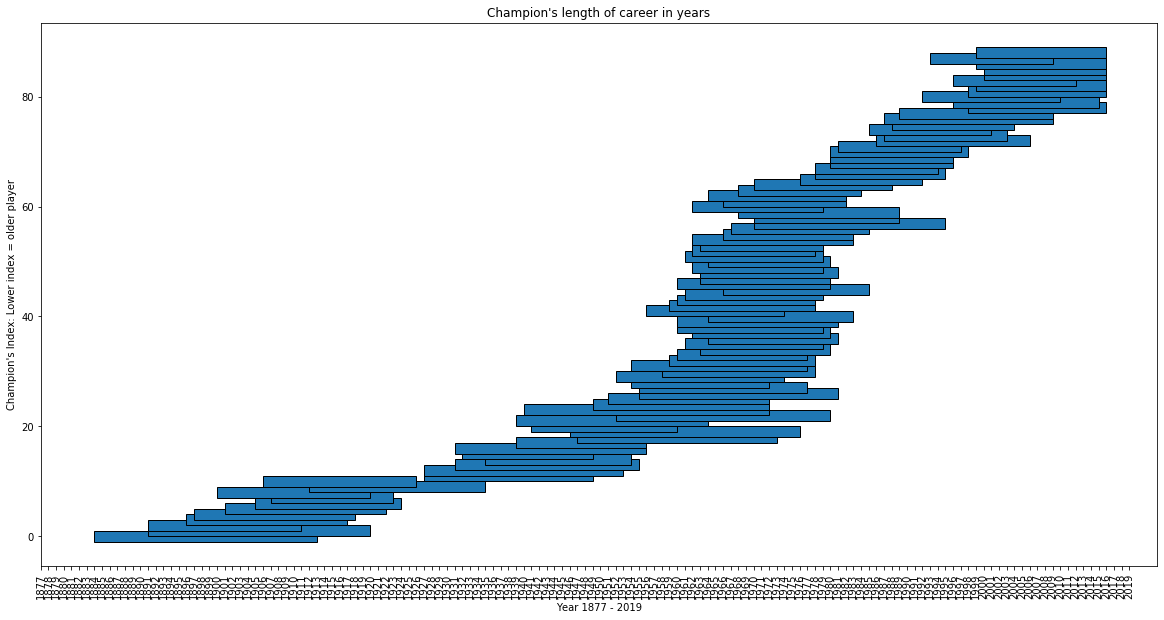

In [19]:
y_pos = np.arange(len(champs['Name']))
plt.figure(figsize=(20,10))
plt.barh(y_pos, champs['Length of career'], height=2, left=champs['Career start'], edgecolor='black')
plt.xticks(range(1877, 2020), rotation=90)
plt.title('Champion\'s length of career in years')
plt.ylabel("Champion's Index: Lower index = older player")
plt.xlabel("Year 1877 - 2019")
plt.show()

# Using requests to harvest data from websites
The goal here was to extract the data from a table on a web page for each of the top 100 ATP players. This is useful because there isnt an API for everything so sometimes you will need an effective way to scrape data off of web pages.
### Step 1:
The first step was to get a feel for how the data was structured on each player's profile page.

### Step 2:
The next step was to extract the data from that page into a list of values inside a dictionary named after the player. During this step I also grabbed the list of column names and saved it as a list for later. 

In [20]:
profileStats = requests.get('https://www.atptour.com/en/players/roger-federer/f324/player-stats').text
profileSoup = BeautifulSoup(profileStats, 'html.parser')
stats = profileSoup.find_all('tr')
stats[3]

<tr>
<td>
			Aces
		</td>
<td>
			11,299
		</td>
</tr>

### Note:
One of the problems that arose was the way the links to the player profiles were structured, https://www.atptour.com/en/players/reilly-opelka/o522/player-stats, because of the irregular "/o522/" part I needed a list of links to query. Below you can see the list of coumns as well as a query of the rankings page that included a link to each ranked player. Below are the links that I collected.

In [21]:
cols = ['Aces', 'Double Faults', '1st Serve', '1st Serve Points Won', '2nd Serve Points Won', 'Break Points Faced', 'Break Points Saved', 'Service Games Played', 'Service Games Won', 'Total Service Points Won', '1st Serve Return Points Won', '2nd Serve Return Points Won', 'Break Points Opportunities', 'Break Points Converted', 'Return Games Played', 'Return Games Won', 'Return Points Won', 'Total Points Won']


In [22]:
def query_page_for_links(link):
    profileStats = requests.get(link).text
    profileSoup = BeautifulSoup(profileStats, 'html.parser')
    stats = profileSoup.find_all('a')
    return stats
    top100players = stats[84:386][0::3]
    print(top100players)
    return top100players

top100_stats = query_page_for_links('https://www.atptour.com/en/rankings/singles')
top100_links = top100_stats[84:386][0::3]
top100_links

[<a data-ga-label="Rafael Nadal" href="/en/players/rafael-nadal/n409/overview">Rafael Nadal</a>,
 <a data-ga-label="Novak Djokovic" href="/en/players/novak-djokovic/d643/overview">Novak Djokovic</a>,
 <a data-ga-label="Roger Federer" href="/en/players/roger-federer/f324/overview">Roger Federer</a>,
 <a data-ga-label="Dominic Thiem" href="/en/players/dominic-thiem/tb69/overview">Dominic Thiem</a>,
 <a data-ga-label="Daniil Medvedev" href="/en/players/daniil-medvedev/mm58/overview">Daniil Medvedev</a>,
 <a data-ga-label="Stefanos Tsitsipas" href="/en/players/stefanos-tsitsipas/te51/overview">Stefanos Tsitsipas</a>,
 <a data-ga-label="Alexander Zverev" href="/en/players/alexander-zverev/z355/overview">Alexander Zverev</a>,
 <a data-ga-label="Matteo Berrettini" href="/en/players/matteo-berrettini/bk40/overview">Matteo Berrettini</a>,
 <a data-ga-label="Roberto Bautista Agut" href="/en/players/roberto-bautista-agut/bd06/overview">Roberto Bautista Agut</a>,
 <a data-ga-label="Gael Monfils" h

#### Step 3:
From each link, I extracted the names of the players and the suffixes of the link to their profile using a for loop and string splicing. These would then be used to call get_player_stats()  on the players personal stats page and build out the dictionary of players. 

In [23]:
def isolate_link_suffixes(links):
    names = []
    suffixes = []

    for item in links:
        item = str(item)
        names.append(item[item.index('="')+2:item.index('" href')])
        print()
        suffixes.append(item[item.index('href="')+6:item.index('/over')])

    print(names[0:5], suffixes[0:5])
    return names, suffixes



#top100_names, top100_suffixes = isolate_link_suffixes(top100_links)


In [24]:
def iterate_links(names, suffixes):
    for i in range(len(names)):
        get_player_stats(suffixes[i], names[i])
    print('Player stats: {}'.format(player_stats))
    

In [25]:
player_stats = {}
    
def get_player_stats(suffix, name):
    s = []
    cols = []

    if name in champs['Name']:
        career_start = champs.loc[champs['Career start'] == name]
        s.append(career_start)
        #print(name)

    profileStats = requests.get('https://www.atptour.com{}/player-stats'.format(suffix)).text
    profileSoup = BeautifulSoup(profileStats, 'html.parser')
    stats = profileSoup.find_all('tr')


    #s[player] = player
    try:
        for i in range(3, 13): # gets a dict of the service record
            col = stats[i].find_all('td')[0].text.strip()
            if col not in cols:
                cols.append(col)
            s.append(stats[i].find_all('td')[1].text.strip())
    except: 
        print('Failed to collect service record for {}'.format(name))

    try:
        for i in range(14, 22): # gets a dict of the return record
            col = stats[i].find_all('td')[0].text.strip()
            if col not in cols:
                cols.append(col)
            s.append(stats[i].find_all('td')[1].text.strip())
    except:
        print('Failed to get return record for {}'.format(name))
            
            
    player_stats[name] = s
    

## All together now
### Now the same process using a list of former number 1's
The link for the list of former number ones is: 'https://www.atptour.com/en/rankings/former-no-1s'
- This link is passed in to the query_page_for_links() function which then slices out the links we need and saves that to the prevNo1_links variable
- Then we isolate the names and suffixes of the players and save those into the prevNo1_names and prevNo1_suffixes
- Calling the iterate_links() function queries each link and assembles the player_stats dictionary 
- Finally we finish up by turning the dictionary into a dataframe, reseting the index and saving it to a csv

In [26]:
# repeat the same process for top 100 players all time
prevNo1_links = query_page_for_links('https://www.atptour.com/en/rankings/former-no-1s')[80:106] # the [80:106] gives me just he links to the player profiles
# can i do a reg ex to get only items that contain 'href="/en/players"'?
prevNo1_names, prevNo1_suffixes = isolate_link_suffixes(prevNo1_links)
iterate_links(prevNo1_names, prevNo1_suffixes)
#player stats has been populated, continue buy saving the resulting dataframe to a csv
pstats = pd.DataFrame.from_dict(player_stats, orient='index', columns=cols)
pstats.reset_index(inplace=True)
pstats.to_csv('previousNumber1-pstats.csv')
#show pstats
player_stats



























['Roger Federer', 'Pete Sampras', 'Novak Djokovic', 'Ivan Lendl', 'Jimmy Connors'] ['/en/players/roger-federer/f324', '/en/players/pete-sampras/s402', '/en/players/novak-djokovic/d643', '/en/players/ivan-lendl/l018', '/en/players/jimmy-connors/c044']
Failed to collect service record for Ilie Nastase
Failed to get return record for Ilie Nastase
Failed to collect service record for John Newcombe
Failed to get return record for John Newcombe
Failed to collect service record for Patrick Rafter
Failed to get return record for Patrick Rafter
Player stats: {'Roger Federer': ['11,299', '2,732', '62%', '77%', '57%', '6,323', '67%', '18,545', '89%', '70%', '33%', '51%', '11,768', '41%', '18,147', '27%', '40%', '54%'], 'Pete Sampras': ['8,713', '2,949', '59%', '81%', '53%', '3,661', '68%', '10,441', '89%', '69%', '29%', '51%', '6,047', '41%', '10,227', '24%', '38%', '54%'], 'Novak Djokovic': ['5,592', '2,341', '65%', '74%', '56%', '5,330', '65%', '12,944', '86%', '67%', 

{'Roger Federer': ['11,299',
  '2,732',
  '62%',
  '77%',
  '57%',
  '6,323',
  '67%',
  '18,545',
  '89%',
  '70%',
  '33%',
  '51%',
  '11,768',
  '41%',
  '18,147',
  '27%',
  '40%',
  '54%'],
 'Pete Sampras': ['8,713',
  '2,949',
  '59%',
  '81%',
  '53%',
  '3,661',
  '68%',
  '10,441',
  '89%',
  '69%',
  '29%',
  '51%',
  '6,047',
  '41%',
  '10,227',
  '24%',
  '38%',
  '54%'],
 'Novak Djokovic': ['5,592',
  '2,341',
  '65%',
  '74%',
  '56%',
  '5,330',
  '65%',
  '12,944',
  '86%',
  '67%',
  '34%',
  '55%',
  '9,076',
  '44%',
  '12,584',
  '32%',
  '42%',
  '54%'],
 'Ivan Lendl': ['1,701',
  '656',
  '56%',
  '76%',
  '52%',
  '1,416',
  '63%',
  '3,024',
  '82%',
  '66%',
  '31%',
  '53%',
  '2,021',
  '42%',
  '3,030',
  '28%',
  '40%',
  '52%'],
 'Jimmy Connors': ['140',
  '196',
  '65%',
  '63%',
  '50%',
  '695',
  '58%',
  '985',
  '70%',
  '58%',
  '32%',
  '53%',
  '685',
  '42%',
  '976',
  '29%',
  '41%',
  '50%'],
 'Rafael Nadal': ['3,449',
  '1,813',
  '68%',
  

### Step 4:
This last step is extra and not necessary. I added a couple columns from our champs dataframe into the prevNo1_pstats dataframe so that we can normalize columns of career total data with the length of career and career start.

In [27]:
pstats = pd.DataFrame.from_dict(player_stats, orient='index', columns=cols)
pstats.reset_index(inplace=True)
pstats.rename(columns={'index':'Name'}, inplace=True)
pstats.head()

,Name,Aces,Double Faults,1st Serve,1st Serve Points Won,2nd Serve Points Won,Break Points Faced,Break Points Saved,Service Games Played,Service Games Won,Total Service Points Won,1st Serve Return Points Won,2nd Serve Return Points Won,Break Points Opportunities,Break Points Converted,Return Games Played,Return Games Won,Return Points Won,Total Points Won
0,Roger Federer,"11,299","2,732",62%,77%,57%,"6,323",67%,"18,545",89%,70%,33%,51%,"11,768",41%,"18,147",27%,40%,54%
1,Pete Sampras,"8,713","2,949",59%,81%,53%,"3,661",68%,"10,441",89%,69%,29%,51%,"6,047",41%,"10,227",24%,38%,54%
2,Novak Djokovic,"5,592","2,341",65%,74%,56%,"5,330",65%,"12,944",86%,67%,34%,55%,"9,076",44%,"12,584",32%,42%,54%
3,Ivan Lendl,"1,701",656,56%,76%,52%,"1,416",63%,"3,024",82%,66%,31%,53%,"2,021",42%,"3,030",28%,40%,52%
4,Jimmy Connors,140,196,65%,63%,50%,695,58%,985,70%,58%,32%,53%,685,42%,976,29%,41%,50%


In [28]:
pstats.to_csv('previousNumber1-pstats.csv')

In [29]:
pstats = pstats.merge(champs, on='Name')

In [30]:
pstats.to_csv('previousNumber1-pstats.csv')
#pstats.drop(['Length of career_x', 'Career start_x'], axis=1)

In [31]:
champs.to_csv('champs.csv')

In [32]:
champs

,Name,Length of career,Career start
0,Henry Slocum,29,1884
1,Arthur Gore,29,1891
2,William Larned,20,1891
3,Holcombe Ward,21,1896
4,Beals Wright,21,1897
...,...,...,...
84,Mikhail Youzhny,16,2000
85,Paul-Henri Mathieu,16,2000
86,Radek Stepanek,17,1999
87,Vincent Spadea,16,1993
